# 분류기의 성능향상 기법

## 손실함수
분류문제- nn.BCELoss() :이진 교차 엔트로피 사용
## 활성화 함수
sigmoid 대신 relu(왼쪽부분기울기)
## Optimizer
sgd 대신 Adam
## 정규화
LayerNorm(200)

In [6]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import pandas

In [7]:
class Classifier(nn.Module):
    
    def __init__(self):
        #부모클래스 초기화
        super().__init__()
        
        #신경망 레이어 정의 
        self.model = nn.Sequential(
            nn.Linear(784,200),
            nn.LeakyReLU(0.02),
            nn.LayerNorm(200),
            nn.Linear(200,10),
            nn.Sigmoid()
        )
        #손실함수
        self.loss_function = nn.BCELoss()
        
        #SGD 옵티마이저
        self.optimiser = torch.optim.Adam(self.parameters(),lr=0.01)
        
        # counter and accumulator for progress
        self.counter = 0
        self.progress = []
        
        pass
    def forward(self,inputs):
        #모델실행
        return self.model(inputs)
    
    def train(self,inputs,targets):
        #신경망 출력 계산
        outputs =self.forward(inputs)
        
        #손실 계산
        loss = self.loss_function(outputs,targets)
        
        # increase counter and accumulate error every 10
        self.counter += 1
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())
            pass
        if (self.counter % 10000 == 0):
            print("counter = ", self.counter)
            pass

        # zero gradients, perform a backward pass, and update the weights
        self.optimiser.zero_grad() #기울기 초기화
        loss.backward() #역전파 실행
        self.optimiser.step() #가중치 갱신

        pass
     
    def plot_progress(self): # 오차 출력 
        df = pandas.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0, 1.0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5))
        pass
    
    pass

In [10]:
class MnistDataset(Dataset):
    def __init__(self,csv_file):
        self.data_df = pandas.read_csv(csv_file,header=None)
        pass
    def __len__(self):
        return len(self.data_df)
    def __getitem__(self,index):
        #이미지 목표(레이블)
        label =self.data_df.iloc[index,0]
        #one hot encoding
        target=torch.zeros((10))
        target[label]=1.0
        
        #0~255의 이미지를 0~1로 정규화
        image_values = torch.FloatTensor(self.data_df.iloc[index,1:].values)/255.0
        # 레이블,이미지,데이터 텐서 ,목표 텐서 반환
        return label,image_values ,target
    def plot_image(self,index):
        img=self.data_df.iloc[index,1:].values.reshape(28,28)
        plt.title("label="+str(self.data_df.iloc[index,0]))
        plt.imshow(img,interpolation='none',cmap='Blues')
        pass
    pass

In [11]:
mnist_dataset=MnistDataset('C:/Users/Songwooseok/mnist_train.csv')


In [13]:
%%time

#신경망 생성
C=Classifier()
#mnist data에 대해 훈련 진행
epochs =1
for i in range(epochs):
    print('training epoch',i+1,"of",epochs)
    for label,image_data_tensor,target_tensor in mnist_dataset:
        C.train(image_data_tensor,target_tensor)
        pass
    pass

training epoch 1 of 1
counter =  10000
counter =  20000
counter =  30000
counter =  40000
counter =  50000
counter =  60000
Wall time: 2min 39s


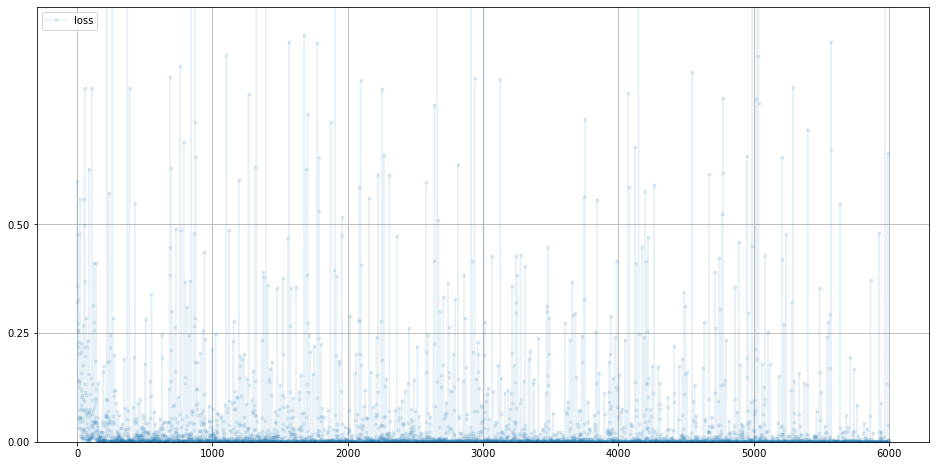

In [14]:
#분류기 오차 출력
C.plot_progress()

## test

In [15]:
mnist_test_dataset=MnistDataset('C:/Users/Songwooseok/mnist_test.csv')


7
tensor([2.6115e-08, 3.3101e-12, 1.8122e-06, 6.7785e-06, 1.7674e-08, 2.1416e-06,
        8.1575e-10, 1.0000e+00, 4.0930e-12, 3.5390e-08],
       grad_fn=<SigmoidBackward>)


<AxesSubplot:>

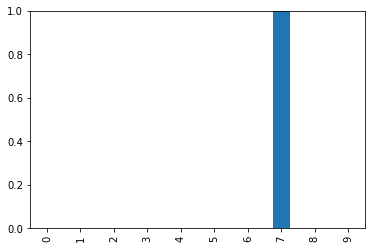

In [16]:
image_data =mnist_test_dataset[17][1]
print(mnist_test_dataset[17][0])
#훈련된 신경망으로부터 쿼리
output = C.forward(image_data)
print(output)
#tensor 출력
pandas.DataFrame(output.detach().numpy()).plot(kind='bar',legend=False,ylim=(0,1))

In [19]:
#%%timeit
score =0
items=0
for label,image_data_tensor,target_tensor in mnist_test_dataset:
    answer =C.forward(image_data_tensor).detach().numpy()
    if (answer.argmax()==label):
        score += 1
        pass
    items +=1
    pass
print(score,items,score/items)

9418 10000 0.9418
